# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                   
Sample_044  Q8NI17;Q8NI17-10;Q8NI17-11;Q8NI17-12;Q8NI17-2;Q8NI17-3;Q8NI17-5;Q8NI17-6;Q8NI17-9   26.926
Sample_172  A0A075B6I9                                                                          20.751
Sample_020  P12277                                                                              15.412
Sample_151  Q9NPH3;Q9NPH3-2;Q9NPH3-5                                                            14.259
Sample_069  A0A0A0MRJ6;F6S8N6;H7BY58;P22061;P22061-2                                            18.122
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                                        
Sample_167  Q9UP79                                                   15.200
Sample_133  E9PHN6;E9PHN7;F6XZQ7;P28161;P28161-2                     13.602
Sample_036  D3YTI2;F2Z2Q9;G5E9R5;P24666;P24666-2;P24666-3;P24666-4   15.679
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.677
            A0A075B6Q5                 12.527
            A0A075B6R2                 14.276
            A0A075B6S5                 11.341
            A0A087WSY4                 13.280
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.235
            Q9UI40;Q9UI40-2            12.091
            Q9UIW2                     12.500
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.169
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.259,15.050,16.842,19.863,15.851,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.853,19.067,...,15.528,15.576,14.249,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.918,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.412,17.705,17.039,16.133,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.365,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.603,15.345,17.084,18.708,14.249,19.433,11.335,11.140
Sample_207,15.739,16.877,15.469,16.898,14.939,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.420,13.047,12.193,12.780,12.387,13.012,12.431,13.160,11.401,14.351
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.122,19.067,16.127,...,13.291,12.383,13.209,12.199,12.892,12.874,12.043,12.401,13.023,11.798
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.643,13.215,12.807,12.490,12.894,13.322,11.967,12.614,13.435,12.463
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.712,13.277,13.621,12.923,12.967,12.788,12.588,14.101,12.313,12.206
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.804,12.947,12.990,12.550,12.931,13.146,14.332,12.627,12.619,13.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.729,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 288.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.73it/s]

100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.50it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.62it/s]

100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.63it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.95it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.19it/s]

100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.76it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.94it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.51it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.36it/s]

100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.08it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.47it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.35it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.27it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.25it/s]

100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

100%|██████████| 7/7 [00:01<00:00,  5.38it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.31it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.90it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.42it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.24it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.32it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.03it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.96it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.21it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.02it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.64it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.63it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.41it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.32it/s]

100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

100%|██████████| 9/9 [00:01<00:00,  4.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.42it/s]

 30%|███       | 3/10 [00:00<00:01,  4.38it/s]

 40%|████      | 4/10 [00:00<00:01,  3.66it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.07it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.73it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.92it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.00it/s]

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.36it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.52it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.58it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.96it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.42it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.13it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.15it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.29it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.46it/s]

100%|██████████| 11/11 [00:02<00:00,  3.62it/s]

100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.03it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.52it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.40it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.03it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.66it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.14it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  3.79it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.61it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.46it/s]

100%|██████████| 12/12 [00:02<00:00,  3.51it/s]

100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.21it/s]

 31%|███       | 4/13 [00:00<00:01,  5.83it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.97it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.82it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.61it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.49it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.17it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.61it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.49it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.10it/s]

100%|██████████| 13/13 [00:03<00:00,  3.02it/s]

100%|██████████| 13/13 [00:03<00:00,  3.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.23it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.46it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.82it/s]

 36%|███▌      | 5/14 [00:01<00:01,  4.56it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.54it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.57it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.43it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.00it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.32it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.06it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.96it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.90it/s]

100%|██████████| 14/14 [00:03<00:00,  2.99it/s]

100%|██████████| 14/14 [00:03<00:00,  3.66it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.19it/s]

 20%|██        | 3/15 [00:00<00:01,  7.24it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.87it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.88it/s]

 40%|████      | 6/15 [00:00<00:01,  5.46it/s]

 47%|████▋     | 7/15 [00:01<00:01,  5.32it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.11it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.87it/s]

 67%|██████▋   | 10/15 [00:01<00:01,  4.68it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.48it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.43it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.56it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.38it/s]

100%|██████████| 15/15 [00:03<00:00,  3.25it/s]

100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.039 0.012          0.547 0.454       0.069   
2             0.004 0.003      0.044 0.018          0.767 0.098       0.711   
3             0.005 0.004      0.047 0.015          0.826 0.089       0.740   
4             0.004 0.003      0.051 0.021          0.783 0.095       0.780   
5             0.006 0.006      0.052 0.019          0.778 0.095       0.756   
6             0.004 0.002      0.041 0.012          0.821 0.075       0.800   
7             0.003 0.000      0.036 0.007          0.823 0.072       0.781   
8             0.004 0.000      0.039 0.008          0.832 0.076       0.807   
9             0.003 0.001      0.025 0.007          0.824 0.078       0.814   
10            0.003 0.001      0.036 0.013          0.822 0.080       0.816   
11            0.003 0.002      0.033 0.012          0.831 0.087       0.830   
12            0.003 0.002      0.035 0.017          0.823 0.087       0.822   
13            0.005 0.003      0.046 0.016          0.822 0.087       0.814   
14            0.004 0.002      0.042 0.014          0.827 0.089       0.816   
15            0.005 0.003      0.043 0.012          0.816 0.089       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.079   0.118 0.123                  0.529 0.037        0.847   
2          0.105   0.732 0.078                  0.774 0.062        0.865   
3          0.100   0.775 0.072                  0.811 0.056        0.870   
4          0.116   0.776 0.081                  0.809 0.067        0.884   
5          0.124   0.760 0.086                  0.797 0.069        0.885   
6          0.087   0.807 0.063                  0.835 0.052        0.909   
7          0.090   0.798 0.063                  0.828 0.052        0.911   
8          0.096   0.816 0.069                  0.843 0.057        0.922   
9          0.096   0.816 0.070                  0.843 0.058        0.923   
10         0.088   0.816 0.067                  0.843 0.057        0.922   
11         0.091   0.827 0.070                  0.852 0.059        0.926   
12         0.099   0.819 0.075                  0.845 0.064        0.924   
13         0.099   0.814 0.074                  0.841 0.063        0.922   
14         0.100   0.818 0.076                  0.844 0.064        0.923   
15         0.096   0.809 0.075                  0.837 0.063        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.821 0.087        210.000 0.000  
2          0.061                  0.838 0.082        210.000 0.000  
3          0.062                  0.843 0.082        210.000 0.000  
4          0.052                  0.859 0.066        210.000 0.000  
5          0.052                  0.860 0.064        210.000 0.000  
6          0.045                  0.895 0.052        210.000 0.000  
7          0.046                  0.897 0.052        210.000 0.000  
8          0.042                  0.909 0.048        210.000 0.000  
9          0.042                  0.911 0.045        210.000 0.000  
10         0.041                  0.911 0.046        210.000 0.000  
11         0.042                  0.915 0.048        210.000 0.000  
12         0.044                  0.912 0.051        210.000 0.000  
13         0.044                  0.910 0.050        210.000 0.000  
14         0.044                  0.911 0.051        210.000 0.000  
15         0.045                  0.910 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 473.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.37it/s]

100%|██████████| 3/3 [00:00<00:00,  8.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.92it/s]

100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.48it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.96it/s]

100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

100%|██████████| 5/5 [00:00<00:00,  7.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.01it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.51it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

100%|██████████| 6/6 [00:00<00:00,  7.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.34it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.62it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.89it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.87it/s]

100%|██████████| 7/7 [00:01<00:00,  5.76it/s]

100%|██████████| 7/7 [00:01<00:00,  6.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.77it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.32it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.81it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.24it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.13it/s]

100%|██████████| 8/8 [00:01<00:00,  6.14it/s]

100%|██████████| 8/8 [00:01<00:00,  6.60it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.83it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.18it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.07it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.91it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.91it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.04it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.07it/s]

100%|██████████| 9/9 [00:01<00:00,  6.05it/s]

100%|██████████| 9/9 [00:01<00:00,  6.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.71it/s]

 40%|████      | 4/10 [00:00<00:00,  7.13it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.84it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.30it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.19it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.26it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.29it/s]

100%|██████████| 10/10 [00:01<00:00,  5.35it/s]

100%|██████████| 10/10 [00:01<00:00,  5.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.30it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.49it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.26it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.79it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.50it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.36it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.37it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.35it/s]

100%|██████████| 11/11 [00:01<00:00,  6.22it/s]

100%|██████████| 11/11 [00:01<00:00,  6.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.80it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.49it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.70it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.46it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.26it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.12it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.21it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.99it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.91it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  5.13it/s]

100%|██████████| 12/12 [00:02<00:00,  4.74it/s]

100%|██████████| 12/12 [00:02<00:00,  5.23it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.44it/s]

 31%|███       | 4/13 [00:00<00:01,  6.65it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.13it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.06it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.23it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.06it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.13it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.83it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.96it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.02it/s]

100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.40it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.33it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.43it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.58it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.68it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  7.64it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.80it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.83it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.87it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.89it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.90it/s]

100%|██████████| 14/14 [00:01<00:00,  7.91it/s]

100%|██████████| 14/14 [00:01<00:00,  7.87it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.38it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.91it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.19it/s]

 40%|████      | 6/15 [00:00<00:01,  6.85it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.72it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.61it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.61it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.61it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.46it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.42it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.23it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.24it/s]

100%|██████████| 15/15 [00:02<00:00,  6.21it/s]

100%|██████████| 15/15 [00:02<00:00,  6.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.001          0.087 0.248       0.009   
2             0.002 0.000      0.022 0.010          0.666 0.117       0.514   
3             0.002 0.001      0.022 0.005          0.800 0.079       0.711   
4             0.002 0.000      0.022 0.005          0.794 0.087       0.724   
5             0.002 0.001      0.023 0.005          0.783 0.089       0.713   
6             0.002 0.001      0.023 0.005          0.799 0.092       0.784   
7             0.002 0.000      0.020 0.003          0.790 0.093       0.791   
8             0.002 0.000      0.023 0.005          0.796 0.095       0.787   
9             0.002 0.001      0.023 0.005          0.797 0.094       0.784   
10            0.002 0.000      0.021 0.003          0.810 0.078       0.808   
11            0.004 0.003      0.033 0.015          0.811 0.078       0.804   
12            0.003 0.002      0.035 0.014          0.811 0.080       0.795   
13            0.002 0.000      0.021 0.001          0.811 0.079       0.795   
14            0.002 0.000      0.020 0.001          0.806 0.080       0.794   
15            0.002 0.000      0.020 0.000          0.803 0.083       0.781   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.863   
2          0.122   0.571 0.098                  0.660 0.066        0.743   
3          0.102   0.748 0.076                  0.790 0.058        0.873   
4          0.110   0.752 0.082                  0.792 0.064        0.873   
5          0.119   0.740 0.084                  0.783 0.066        0.873   
6          0.104   0.786 0.074                  0.818 0.061        0.899   
7          0.105   0.785 0.073                  0.816 0.062        0.899   
8          0.114   0.785 0.080                  0.817 0.067        0.898   
9          0.111   0.785 0.076                  0.817 0.063        0.897   
10         0.104   0.804 0.069                  0.833 0.058        0.910   
11         0.102   0.802 0.065                  0.832 0.054        0.910   
12         0.107   0.798 0.070                  0.828 0.058        0.908   
13         0.110   0.797 0.070                  0.828 0.058        0.906   
14         0.111   0.794 0.071                  0.826 0.058        0.905   
15         0.111   0.786 0.072                  0.819 0.059        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.829 0.087        210.000 0.000  
2          0.077                  0.679 0.100        210.000 0.000  
3          0.052                  0.830 0.074        210.000 0.000  
4          0.052                  0.832 0.073        210.000 0.000  
5          0.052                  0.831 0.073        210.000 0.000  
6          0.050                  0.873 0.065        210.000 0.000  
7          0.051                  0.871 0.065        210.000 0.000  
8          0.052                  0.872 0.066        210.000 0.000  
9          0.053                  0.870 0.067        210.000 0.000  
10         0.050                  0.887 0.064        210.000 0.000  
11         0.049                  0.885 0.063        210.000 0.000  
12         0.049                  0.883 0.064        210.000 0.000  
13         0.050                  0.881 0.064        210.000 0.000  
14         0.049                  0.880 0.064        210.000 0.000  
15         0.048                  0.884 0.061 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1238.72it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 66.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 50.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 44.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.03it/s]

100%|██████████| 5/5 [00:00<00:00, 42.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.60it/s]

100%|██████████| 6/6 [00:00<00:00, 40.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 42.51it/s]

100%|██████████| 7/7 [00:00<00:00, 39.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 42.60it/s]

100%|██████████| 8/8 [00:00<00:00, 39.06it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 42.67it/s]

100%|██████████| 9/9 [00:00<00:00, 38.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 42.68it/s]

100%|██████████| 10/10 [00:00<00:00, 37.22it/s]

100%|██████████| 10/10 [00:00<00:00, 37.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 42.54it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.25it/s]

100%|██████████| 11/11 [00:00<00:00, 37.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.36it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 37.70it/s]

100%|██████████| 12/12 [00:00<00:00, 37.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.20it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 37.46it/s]

100%|██████████| 13/13 [00:00<00:00, 37.33it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.06it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 37.60it/s]

100%|██████████| 14/14 [00:00<00:00, 36.15it/s]

100%|██████████| 14/14 [00:00<00:00, 36.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 42.90it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 37.24it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 35.97it/s]

100%|██████████| 15/15 [00:00<00:00, 36.55it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.611 0.131       0.386   
3             0.002 0.000      0.020 0.000          0.659 0.108       0.551   
4             0.002 0.000      0.020 0.000          0.664 0.095       0.620   
5             0.002 0.000      0.020 0.001          0.671 0.094       0.610   
6             0.002 0.000      0.020 0.000          0.675 0.098       0.601   
7             0.002 0.000      0.020 0.000          0.662 0.087       0.639   
8             0.002 0.000      0.020 0.000          0.688 0.079       0.641   
9             0.002 0.000      0.020 0.000          0.684 0.084       0.640   
10            0.002 0.000      0.020 0.000          0.692 0.085       0.636   
11            0.002 0.000      0.020 0.000          0.677 0.088       0.624   
12            0.002 0.000      0.020 0.000          0.676 0.091       0.617   
13            0.002 0.000      0.020 0.000          0.687 0.094       0.654   
14            0.002 0.000      0.020 0.001          0.685 0.094       0.655   
15            0.002 0.000      0.021 0.000          0.673 0.095       0.646   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.099   0.465 0.095                  0.599 0.062        0.654   
3          0.107   0.594 0.091                  0.669 0.070        0.742   
4          0.125   0.635 0.097                  0.695 0.074        0.790   
5          0.118   0.633 0.091                  0.695 0.069        0.793   
6          0.121   0.629 0.092                  0.693 0.069        0.789   
7          0.119   0.644 0.088                  0.699 0.068        0.803   
8          0.117   0.658 0.083                  0.713 0.064        0.803   
9          0.114   0.656 0.083                  0.711 0.065        0.801   
10         0.118   0.656 0.082                  0.713 0.065        0.801   
11         0.115   0.643 0.084                  0.701 0.065        0.793   
12         0.114   0.639 0.086                  0.698 0.067        0.789   
13         0.114   0.664 0.087                  0.716 0.071        0.798   
14         0.117   0.663 0.088                  0.715 0.072        0.795   
15         0.117   0.655 0.093                  0.707 0.076        0.790   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.693 0.083        210.000 0.000  
2          0.074                  0.620 0.073        210.000 0.000  
3          0.065                  0.695 0.069        210.000 0.000  
4          0.067                  0.737 0.082        210.000 0.000  
5          0.065                  0.747 0.079        210.000 0.000  
6          0.066                  0.745 0.079        210.000 0.000  
7          0.065                  0.752 0.082        210.000 0.000  
8          0.064                  0.750 0.079        210.000 0.000  
9          0.066                  0.748 0.082        210.000 0.000  
10         0.062                  0.749 0.076        210.000 0.000  
11         0.065                  0.743 0.080        210.000 0.000  
12         0.066                  0.734 0.082        210.000 0.000  
13         0.067                  0.742 0.086        210.000 0.000  
14         0.067                  0.737 0.084        210.000 0.000  
15         0.067                  0.732 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,11,15
score_time,5,12,15
test_precision,8,11,10
test_recall,11,10,14
test_f1,11,10,13
test_balanced_accuracy,11,10,13
test_roc_auc,11,10,8
test_average_precision,11,10,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 15.85it/s]

 40%|████      | 4/10 [00:00<00:00, 10.16it/s]

 60%|██████    | 6/10 [00:00<00:00,  8.48it/s]

 70%|███████   | 7/10 [00:00<00:00,  8.48it/s]

 80%|████████  | 8/10 [00:00<00:00,  8.33it/s]

 90%|█████████ | 9/10 [00:01<00:00,  8.30it/s]

100%|██████████| 10/10 [00:01<00:00,  8.31it/s]

100%|██████████| 10/10 [00:01<00:00,  8.76it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 42.71it/s]

100%|██████████| 8/8 [00:00<00:00, 38.94it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.56it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.99it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.67it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.26it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.03it/s]

100%|██████████| 11/11 [00:01<00:00, 10.55it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


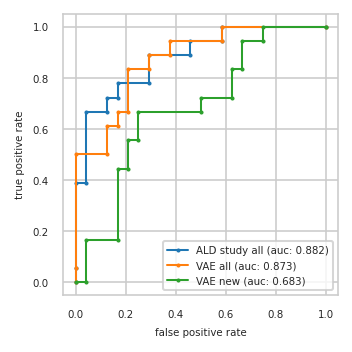

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.500   0.042 0.167
3          0.042 0.389   0.125 0.500   0.167 0.167
4          0.042 0.667   0.125 0.611   0.167 0.444
5          0.125 0.667   0.167 0.611   0.208 0.444
6          0.125 0.722   0.167 0.667   0.208 0.556
7          0.167 0.722   0.208 0.667   0.250 0.556
8          0.167 0.778   0.208 0.833   0.250 0.667
9          0.292 0.778   0.292 0.833   0.500 0.667
10         0.292 0.889   0.292 0.889   0.500 0.722
11         0.458 0.889   0.375 0.889   0.625 0.722
12         0.458 0.944   0.375 0.944   0.625 0.833
13         0.583 0.944   0.583 0.944   0.667 0.833
14         0.583 1.000   0.583 1.000   0.667 0.944
15         1.000 1.000   1.000 1.000   0.750 0.944
16           NaN   NaN     NaN   NaN   0.750 1.000
17           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,H3BLU2,Q9NX62,Q9UI40;Q9UI40-2
2,P02766,P08253,J3KSJ8;Q9UD71;Q9UD71-2
3,Q6UX72,P14174,P31321
4,P04075,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P61981,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
6,P14174,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q9Y2T3;Q9Y2T3-3,P04075,Q96GD0
8,P05413;S4R371,A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16...,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


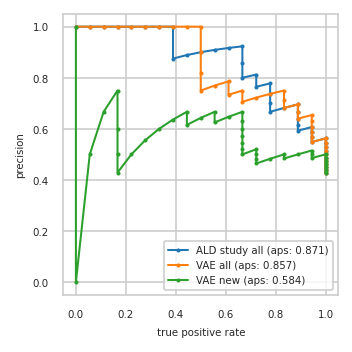

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.615 0.889     0.654 0.944     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.500 0.667
19         0.696 0.889     0.696 0.889     0.522 0.667
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.737 0.778     0.737 0.778     0.632 0.667
24         0.778 0.778     0.722 0.722     0.667 0.667
25         0.765 0.722     0.706 0.667     0.647 0.611
26         0.812 0.722     0.750 0.667     0.625 0.556
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


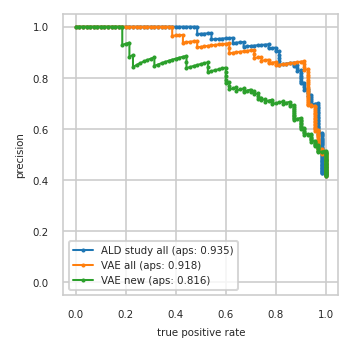

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


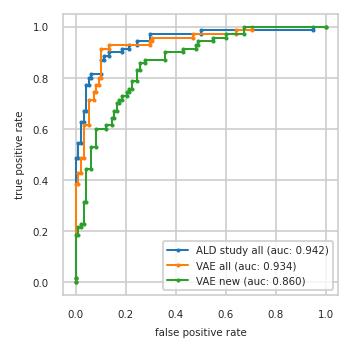

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}